# 暂时不考虑正则化，先直接莽一莽

&nbsp;
## Cell 1: 
#### Standardization 函数，取得 data_mean 和 data_std_variance 只是偷懒用的添头，而且只用一次——无关紧要
&nbsp;
#### 顺便，我们先确定了loss函数的形式：
&nbsp;
# &emsp; loss($\vec{\omega}$) = ${ \sum_{ i=0 } ^ { m } } \frac{ ( y_{ i } - \vec{ \omega } · \vec{ x }_{ i } )^2 }{ 2m }$
&nbsp;
#### 其中 m 表示所选数据集的样本总数，
#### $\vec{ \omega }$ 是线性回归模型的待求参数，
#### $y_{ i }$ 是第i个样本的待预测属性的真实值，
#### $\vec{ x }_{ i }$ 是第i个样本的特征组成的向量 (有一个分量的值固定为1)
&nbsp;

In [ ]:
# Cell 1

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def Standardization(data_list):
    data_mean = np.mean(data_list)
    data_std_variance = np.std(data_list)
    std_data_list = [(data - data_mean) / data_std_variance for data in data_list]
    return std_data_list, data_mean, data_std_variance

def Predict(vector_feature_list, vector_parameter):
    return [np.dot(vector_parameter, vector_feature) for vector_feature in vector_feature_list]

def Get_Loss(error_list):
    return np.linalg.norm(error_list) ** 2 / 2.0 / len(error_list)

&nbsp;
## Cell 2: 
#### 从绝对路径读取得到 source_data ( 类型: data frame )
#### 我们选择 source_data 末尾的10个样本作为 Validation Set
#### 并且通过输出预览 source_data 的基本情况
&nbsp;

In [ ]:
# Cell 2

source_data_abs_path = 'E:/Python Program File/regress_data2.csv'
source_data = pd.read_csv(source_data_abs_path)

line_num = source_data.shape[0]
column_num = source_data.shape[1]
validation_set_size = 10
train_set_size = line_num - validation_set_size

print(source_data.tail(validation_set_size))
print(source_data.describe())

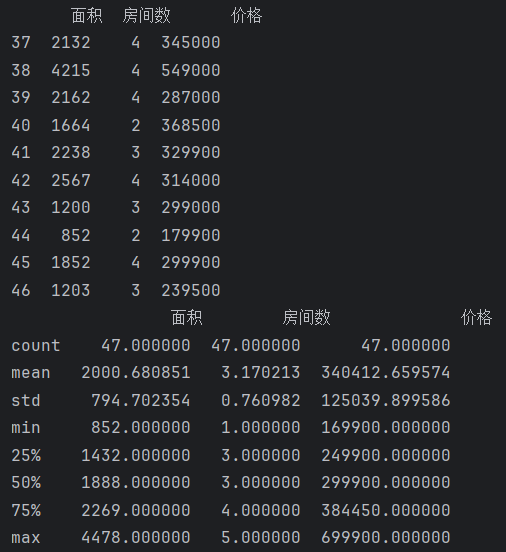

In [2]:
from IPython.display import Image 
Image("./fig1.png")

&nbsp;
## Cell 3
#### 按照先前的划分方案，读取 source_data 中的 Train Set 部分
#### Price <- Price / 1000 可以方便作图，但笔者不确定该步骤对后续求解 $\vec{ \omega }$ 的影响
#### 作三维散点图，预览 标准化之前的样本 特征的基本情况
&nbsp;

In [ ]:
# Cell 3

data_list_list = []
for i in range(column_num):
    data_list_list.append(source_data.iloc[:, i])

area_list = data_list_list[0][0: train_set_size]
room_num_list = data_list_list[1][0: train_set_size]
price_list = data_list_list[2][0: train_set_size]
price_list /= 1000

figure = plt.figure()
subplot = figure.add_subplot(projection='3d')
subplot.plot(area_list, room_num_list, price_list,
             marker='o', markersize=5,
             markerfacecolor='brown', markeredgecolor='orange', linestyle='none')

subplot.set_title('Preview of Train Sets')
subplot.set_xlabel('Area', fontsize=10)
subplot.set_ylabel('Room Number', fontsize=10)
subplot.set_zlabel('(Price/1000)', fontsize=10)
plt.show()

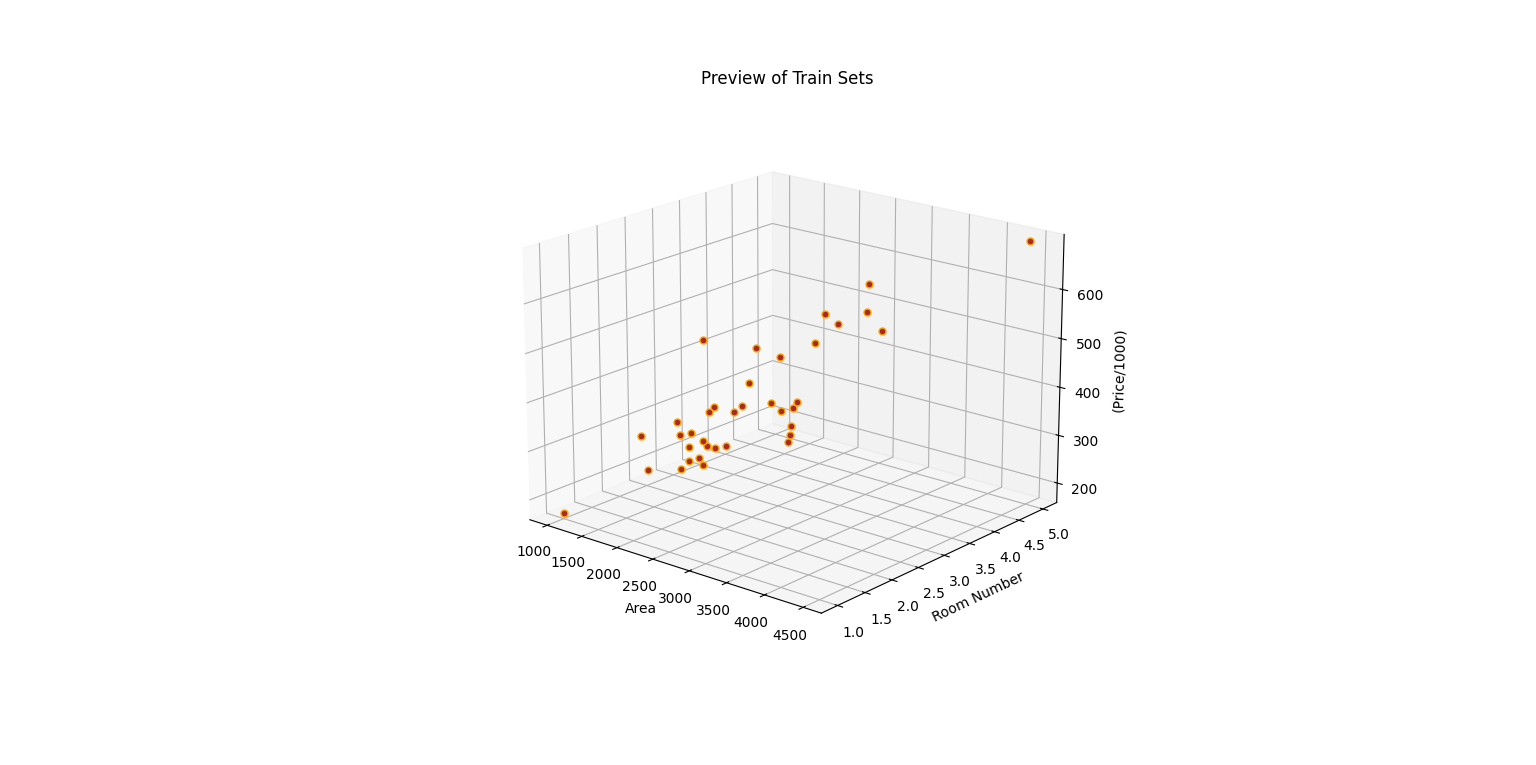

In [6]:
from IPython.display import Image 
Image("./fig2.png")

## Cell 4:
#### 对训练集中的数据进行标准化，
#### 取得训练集各项数据的均值和标准差，
#### 并且准备好用于求解 $\vec{ \omega }$ 的 $\vec{ x }_{ i }$
&nbsp;
## 对于标准化处理后的训练集，之后就认为当中的元素服从标准正态分布了
&nbsp;

In [ ]:
# Cell 4

# Assumption: Gaussian Distributed

std_area_list, area_mean, area_std_variance = Standardization(area_list)
std_room_num_list, room_num_mean, room_num_std_variance = Standardization(room_num_list)

feature_vector_list = []
for i in range(train_set_size):
    feature_vector_list.append([std_area_list[i], std_room_num_list[i], 1.0])

&nbsp;
## Cell 5:
## 这一步是 Batch Gradient Descent 的运用
#### 初始化 loss_history_list 以便记录训练过程中loss函数值的变化
#### 初始化 omega_list 以选择梯度下降方法的起点
#### learning_rate 固定为0.2，不是最好的做法，但不妨试试。
## 然后进入关键流程
&nbsp;
#### 先拜一拜初等微积分，请看下图:
&nbsp;

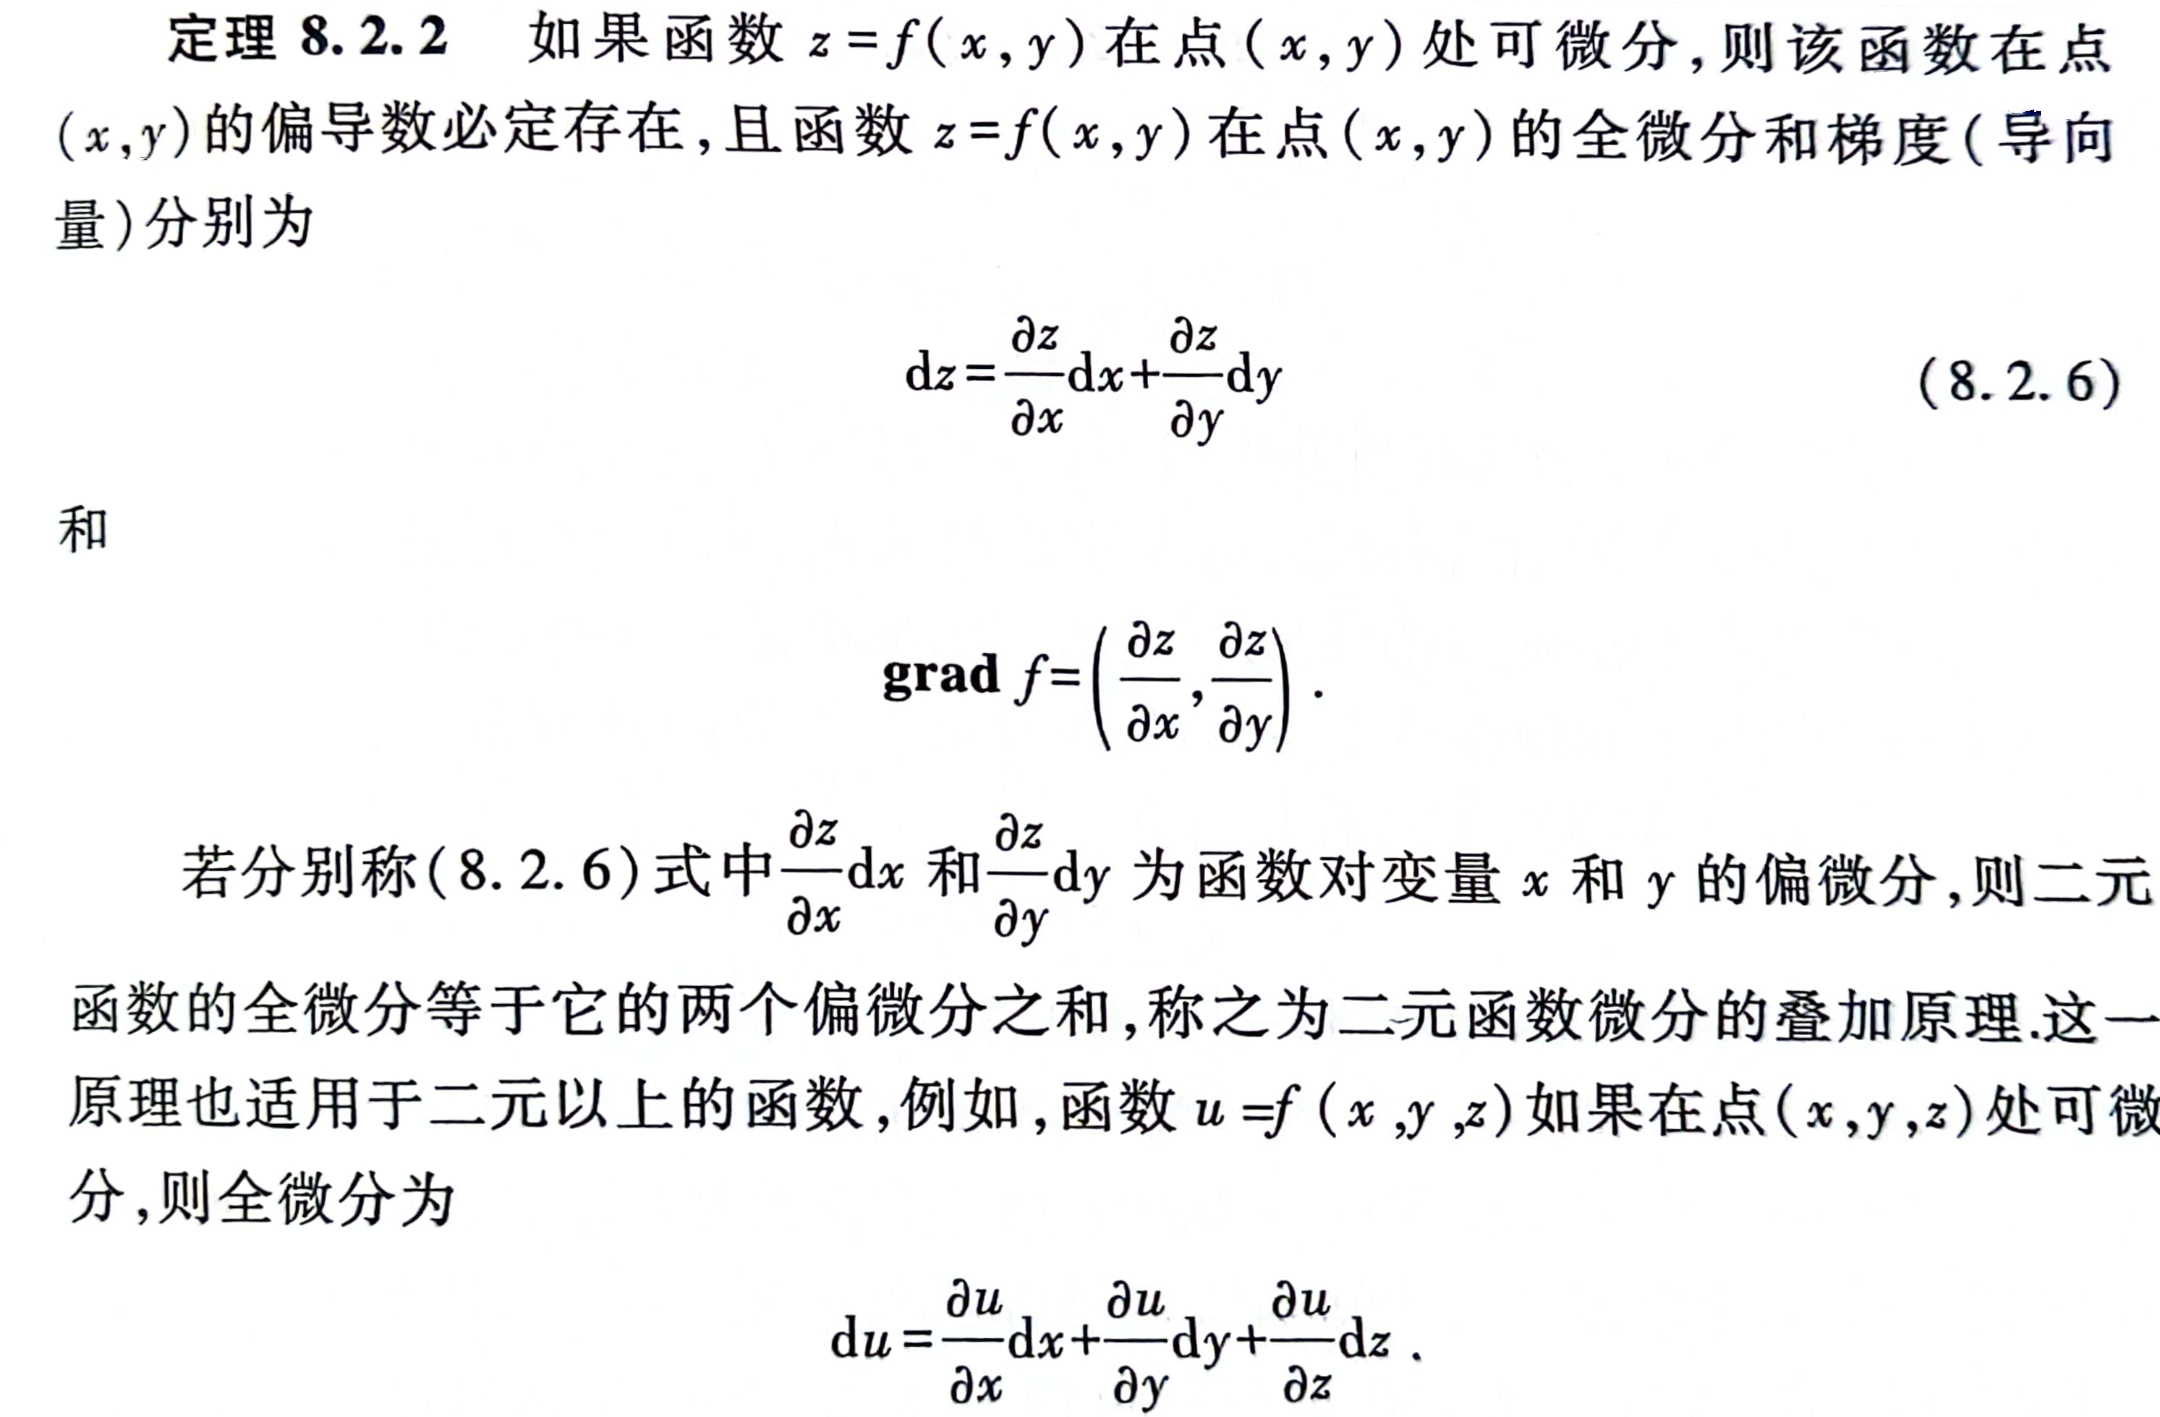

In [9]:
from IPython.display import Image 
Image("./theory1.jpg")

&nbsp;
#### 照猫画虎，研究一下loss函数，发现给定 $\vec{ \omega }$ 就可以求得具体的偏导数值:
&nbsp;
# &emsp;$\frac{ \partial loss }{ \partial \omega_{ i } } $($\vec{ \omega }$) = ${ \sum_{ j=1 } ^ { m } }$ -$\frac{ x_{ji} }{ m }$($y_{ j } - \vec{ \omega } · \vec{ x }_{ j }$)
&nbsp;
#### 其中 $\omega_{ i }$ 代表 $\vec{ \omega }$ 的第i个分量, $x_{ji}$ 代表 $\vec{ x }_{ j }$ 的第i个分量
&nbsp;
#### 于是一系列偏导数值就构成了当次更新 omega_list 所需的 gradient_vector
#### 因为是根据梯度"下山"，所以最后 omega_list -= gradient_array * learning_rate

In [ ]:
# Cell 5

# Q:How to give better initial guess

loss_history_list = []
omega_list = [0.0, 0.0, 0.0]
learning_rate = 0.2

# Q:How to upgrade learning rate

for loop_count in range(100):

    gradient_vector = [0.0, 0.0, 0.0]
    prediction_list = Predict(feature_vector_list, omega_list)
    error_list = price_list - prediction_list
    loss = Get_Loss(error_list)
    loss_history_list.append(loss)

    for i in range(len(gradient_vector)):
        for j in range(len(feature_vector_list)):
            gradient_vector[i] += (-2) * error_list[j] * feature_vector_list[j][i]

    gradient_array = np.array(gradient_vector)
    gradient_array /= 2.0*len(feature_vector_list)
    omega_list -= gradient_array * learning_rate

&nbsp;
## Cell 6:
#### 简单的可视化操作
#### 方便评估训练效率和拟合效果
&nbsp;

In [ ]:
#Cell 6

x_list = [i for i in range(100)]
figure = plt.figure()
subplot = figure.add_subplot()
subplot.plot(x_list, loss_history_list,
             marker='^', markersize=5,
             markerfacecolor='orange', markeredgecolor='orange')

subplot.set_title('Loss - Loop Count in Training Process')
subplot.set_xlabel('Loop Count', fontsize=10)
subplot.set_ylabel('Loss', fontsize=10)
plt.show()

figure = plt.figure()
subplot = figure.add_subplot(projection='3d')
subplot.plot(std_area_list, std_room_num_list, price_list,
             marker='o', markersize=5,
             markerfacecolor='brown', markeredgecolor='orange', linestyle='none')

x = np.linspace(-4, 4, 80)
y = np.linspace(-4, 4, 80)
x, y = np.meshgrid(x, y)
z = (omega_list[0] * x + omega_list[1] * y + omega_list[2])
subplot.plot_surface(x, y, z)

subplot.set_title('Get The Wonderful Plane')
subplot.set_xlabel('STD Area', fontsize=10)
subplot.set_ylabel('STD Room Number', fontsize=10)
subplot.set_zlabel('(Price/1000)', fontsize=10)
plt.show()

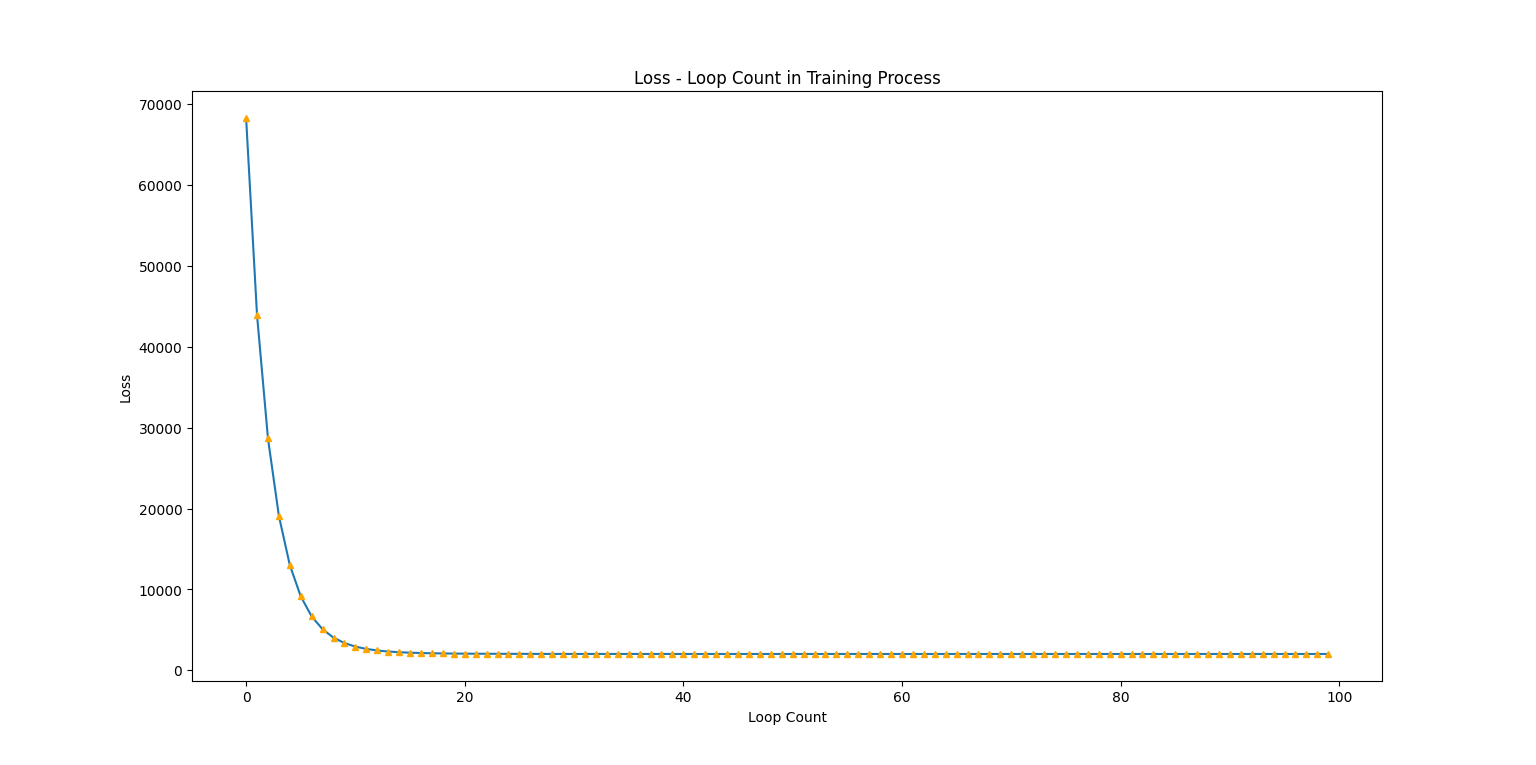

In [15]:
from IPython.display import Image 
Image("./fig3.png")

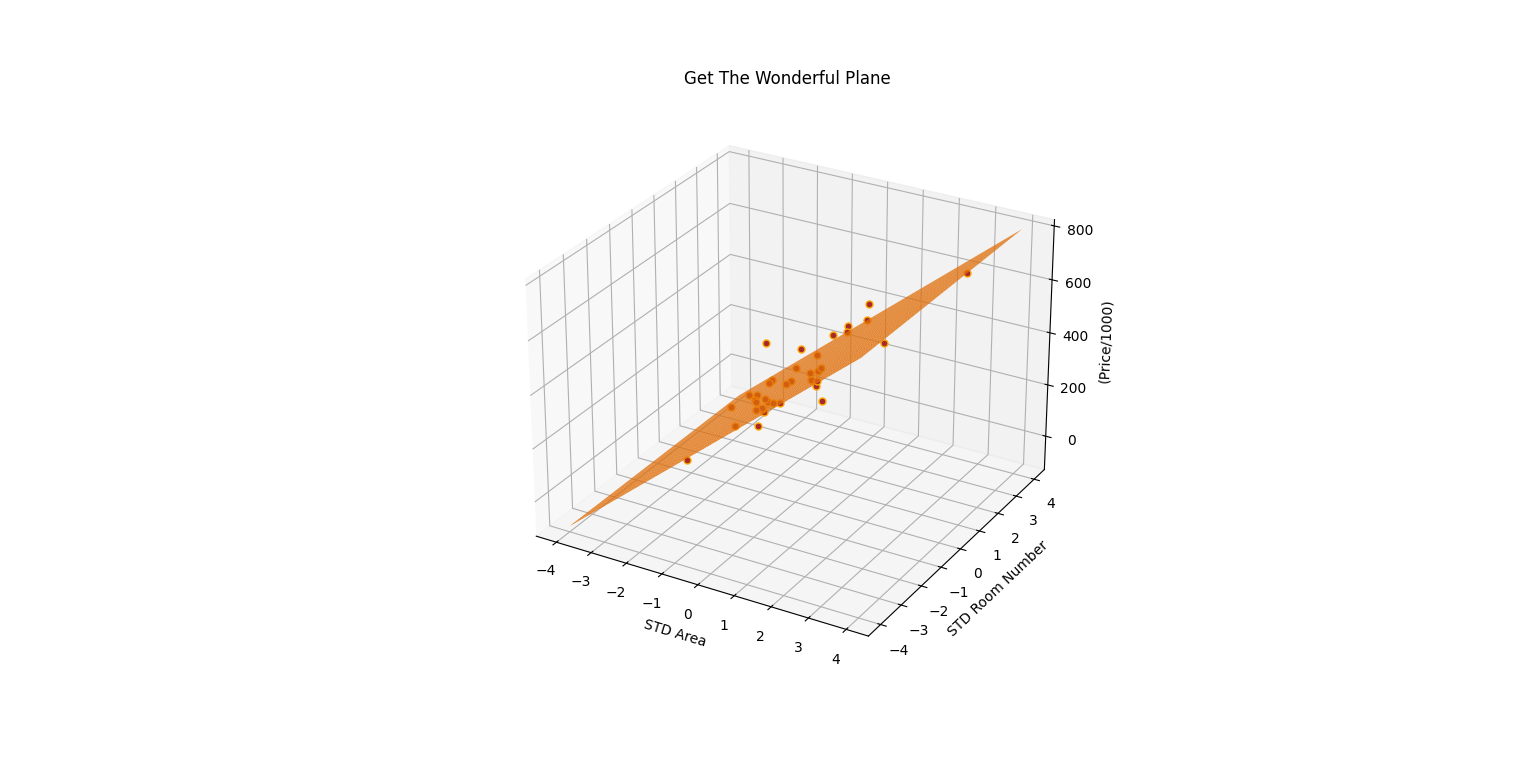

In [16]:
from IPython.display import Image 
Image("./fig4.png")

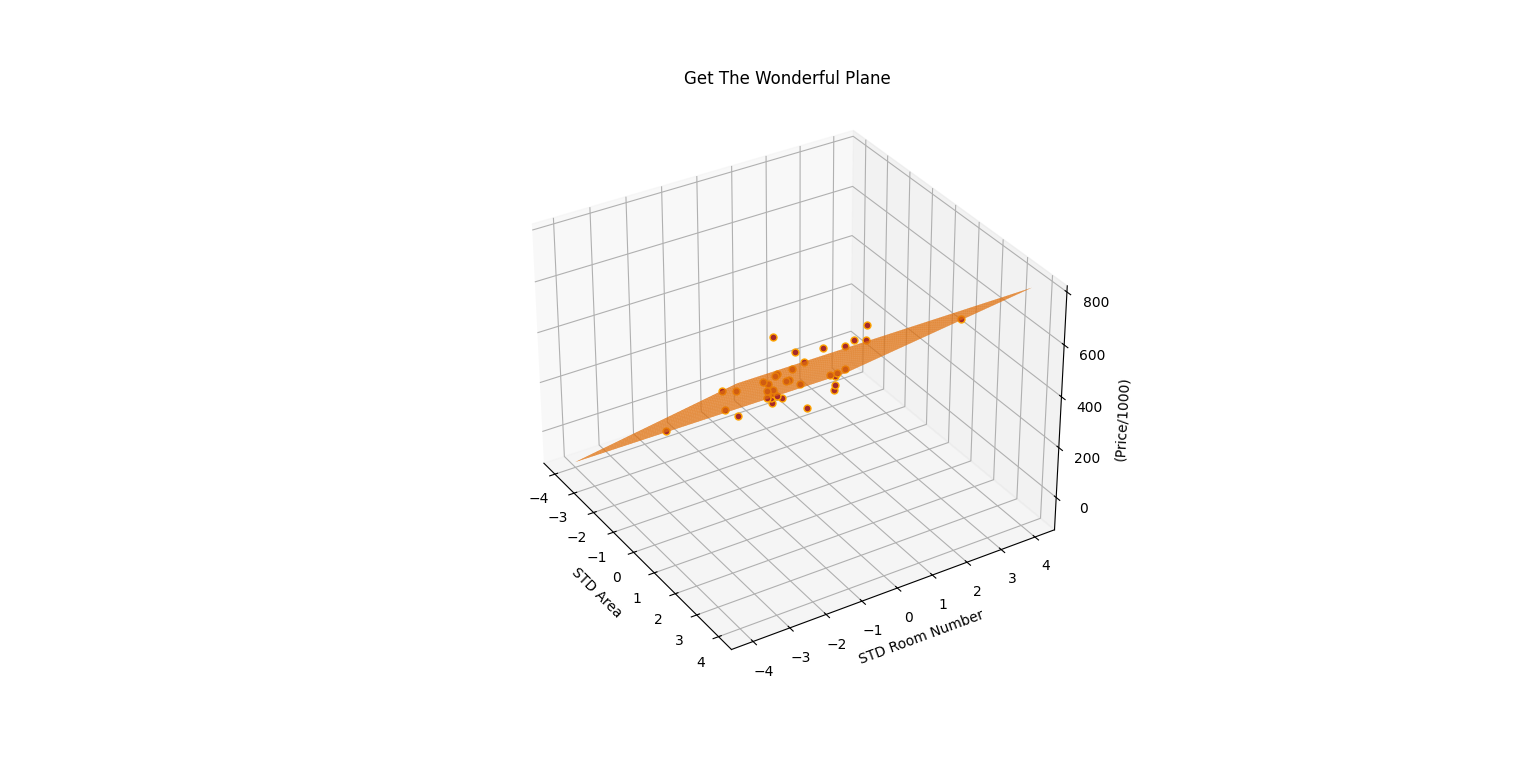

In [17]:
from IPython.display import Image 
Image("./fig5.png")

## Cell 7:
#### 完成对 Validation Set 的回归
#### 注意这里认为 Validation Set 和 Train Set 的元素是独立同分布的关系
#### 所以标准化操作时要复用先前求得的 Train Set 的均值和标准差
#### 最后额外输出整个 Validation Set 的回归所得的loss值

In [ ]:
# Cell 7

val_area_list = data_list_list[0][train_set_size: line_num]
val_room_num_list = data_list_list[1][train_set_size: line_num]
val_price_list = data_list_list[2][train_set_size: line_num]
val_price_list /= 1000

std_val_area_list = [(area - area_mean) / area_std_variance for area in val_area_list]
std_val_room_num_list = [(room_num - room_num_mean) / room_num_std_variance for room_num in val_room_num_list]

feature_vector_list = []
for i in range(validation_set_size):
    feature_vector_list.append([std_val_area_list[i], std_val_room_num_list[i], 1.0])

prediction_list = Predict(feature_vector_list, omega_list)
val_error_list = val_price_list - prediction_list
loss = Get_Loss(val_error_list)

figure = plt.figure()
subplot = figure.add_subplot(projection='3d')
subplot.plot(std_val_area_list, std_val_room_num_list, val_price_list,
             marker='o', markersize=5,
             markerfacecolor='brown', markeredgecolor='orange', linestyle='none')

x = np.linspace(-4, 4, 80)
y = np.linspace(-4, 4, 80)
x, y = np.meshgrid(x, y)
z = (omega_list[0] * x + omega_list[1] * y + omega_list[2])
subplot.plot_surface(x, y, z)

subplot.set_title('Validation')
subplot.set_xlabel('STD Area', fontsize=10)
subplot.set_ylabel('STD Room Number', fontsize=10)
subplot.set_zlabel('(Price/1000)', fontsize=10)
plt.show()

print('Stabled Loss Value of Training Process: '+str(loss_history_list[99]))
print('Loss Value of Validation Task: '+str(loss))

#### Stabled Loss Value of Training Process: 2027.2547872027424
#### Loss Value of Validation Task: 2646.5551344115825

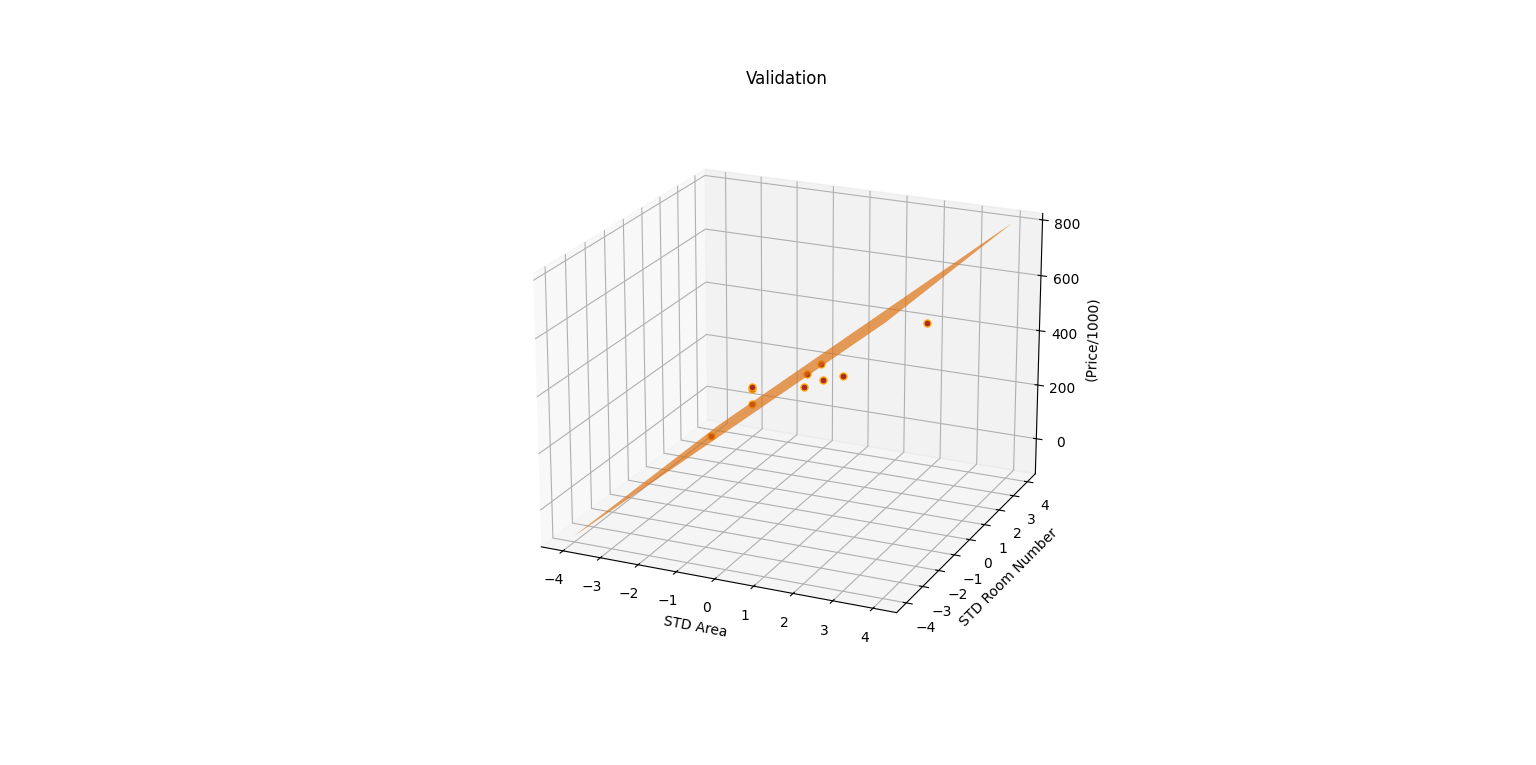

In [10]:
from IPython.display import Image 
Image("./fig6.png")

## 现在考虑引入正则化吧